### Generate pairplots of unselected and selected libraries 

Figure out how much and how consistently they've been selected


In [2]:
# import packages, define correlation function for pairplots 
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from numpy import cov
import seaborn as sns
from itertools import islice

pd.set_option('display.max_columns', None)
sns.set(style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    

In [3]:
# This information has to be input manually: File names, barcode flank sequences 

datasets = \
    {
    'NP_11_25'    : 'NP_11_25_BCCounts.csv',    # PacBio of glycerol stock
#     'NP_11_24_01' : 'NP_11_24_01_BCCounts.csv', # illumina of glycerol stock
    'NP_11_30_1_1': 'NP_11_30_1_BCCounts.csv',  # illumina of glycerol stock more reads
    'NP_11_24_10' : 'NP_11_24_10_BCCounts.csv', # Glycerol1 full aliquot outgrowth
    'NP_11_24_11' : 'NP_11_24_11_BCCounts.csv', # Glycerol2 full aliquot outgrowth
    'NP_11_24_18' : 'NP_11_24_18_BCCounts.csv', # Glycerol1 outgrowth fewer PCR steps
    'NP_11_24_19' : 'NP_11_24_19_BCCounts.csv', # Glycerol2 outgrowth fewer PCR steps
    'NP_11_27_21' : 'NP_11_27_21_BCCounts.csv', # Glycerol stock pick
    'NP_11_27_22' : 'NP_11_27_22_BCCounts.csv', # Preselection outgrowth (no aTc)
    'NP_11_27_23' : 'NP_11_27_23_BCCounts.csv', # Preselection outgrowth (with aTc)
    'NP_11_27_24' : 'NP_11_27_24_BCCounts.csv', # Selection replicate 1
    'NP_11_27_25' : 'NP_11_27_25_BCCounts.csv'  # Selection replicate 2
    }

PBlookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
PBallBCs = 'NP_11_25'
illuminaGlycerol = 'NP_11_30_1_1'
outgrowths = list(islice(datasets,2,9))
selections = list(islice(datasets,9,11))

# Make a dataframe with all of the data (each barcode and its frequency in each dataset)
# Switch to outer merges so that all data is retained at each step

BCDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = {'Barcode_sequence':'Barcode'})

for experiment in datasets:
    dataDF = pd.read_csv(datasets[experiment])
    BCDF = BCDF.merge(dataDF, how = 'outer', on = 'Barcode')


In [4]:
# Total reads per dataset
for experiment in datasets:
    print(experiment + ' had ' + str(BCDF[experiment].sum()) + ' reads')

NP_11_25 had 3612567.0 reads
NP_11_30_1_1 had 4960248.0 reads
NP_11_24_10 had 4367467.0 reads
NP_11_24_11 had 3455440.0 reads
NP_11_24_18 had 4373396.0 reads
NP_11_24_19 had 5084838.0 reads
NP_11_27_21 had 2661367.0 reads
NP_11_27_22 had 2356236.0 reads
NP_11_27_23 had 53884411.0 reads
NP_11_27_24 had 63829406.0 reads
NP_11_27_25 had 66941750.0 reads


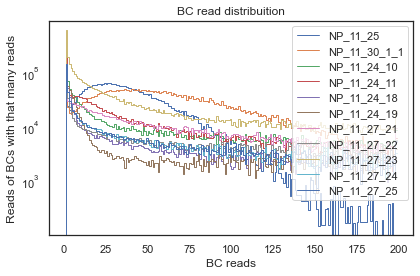

In [5]:
# Reads histograms
# NP_11_32_9a

histData = []

for experiment in datasets:
    data = np.histogram(BCDF[experiment], \
                 bins = range(0,200,1))
    histData.append(data)

for i, experiment in enumerate(datasets):
    xVals = histData[0][1][1:]
    yVals = histData[i][0]
    corrYVals = []
    for j, count in enumerate(yVals):
        corrYVals.append(count * (xVals[j] - 1))
    plt.step(xVals, corrYVals, label = experiment, linewidth = 1)

plt.yscale("log")
plt.legend()
plt.title('BC read distribuition')
plt.ylabel('Reads of BCs with that many reads')
plt.xlabel('BC reads')
plt.yscale('log')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (7,7)

plt.savefig('NP_11_29_barcodesHist.pdf')


In [6]:
# Get normalized enrichment values on a log scale and perform averages
    
# # # Add 0.01 to each value so that there are no errors
# # naValues = {i : 0.01 for i in listOfFileNames}
# # filledInBCDF = BCDF#.fillna(value=naValues)

# Get enrichment value
# Normalize to total reads
for experiment in datasets:
    if experiment != 'NP_11_25':
        reads = BCDF[experiment]
        totalReads = reads.sum()
        pacbioTotalReads = BCDF['NP_11_25'].sum()
        BCDF[experiment + '_norm_enrich'] = np.log((reads/totalReads)/(BCDF['NP_11_25']/pacbioTotalReads))

# Get enrichment value
# Normalize to total reads
for experiment in selections:
    BCDF[experiment + '_selection_enrich'] = BCDF[experiment + '_norm_enrich'] - BCDF['NP_11_27_23_norm_enrich']


In [7]:
# Get average and std. dev. across mutants for each replicate
# Collapse to one row per mutant in separate dataframe

mutDF = BCDF[['correctedAAmut']].drop_duplicates()
for dataset in ([illuminaGlycerol] + outgrowths + selections):
    if dataset in ([illuminaGlycerol] + outgrowths):
        column = dataset + '_norm_enrich'
    if dataset in selections:
        column = dataset + '_selection_enrich'    
    mutAvgs = BCDF.groupby(['correctedAAmut'])[column].mean().to_frame(name = dataset + '_mutAvgLog')
    mutStDevs = BCDF.groupby(['correctedAAmut'])[column].std().to_frame(name = dataset + '_mutStDevLog')
    mutDF = mutDF.merge(mutAvgs, on = 'correctedAAmut')
    mutDF = mutDF.merge(mutStDevs, on = 'correctedAAmut')
    BCDF = BCDF.merge(mutAvgs, how = 'outer', on = 'correctedAAmut')
    BCDF = BCDF.merge(mutStDevs, how = 'outer', on = 'correctedAAmut')


In [8]:
# Get average of averages, average of standard deviations as new columns
# Separate for outgrowths and selections, all barcodes and mutant

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['outgrowths_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['outgrowths_stDev'] = BCDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['selections_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['selections_stDev'] = BCDF[columnsToAvg].std(axis = 1)

# There are two distinct standard deviations here!

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['outgrowths_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['outgrowths_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)
columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['outgrowths_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['selections_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['selections_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['selections_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)



Text(0.5, 1.01, 'Glycerol stock: PacBio vs. Illumina')

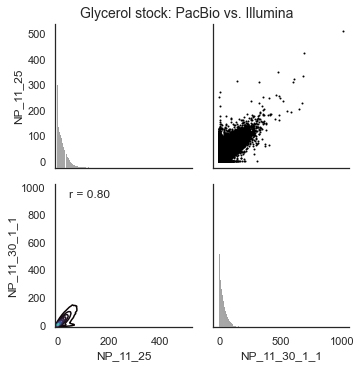

In [9]:
# Pairplot of PacBio vs. illumina of glycerol stocks raw read values
# NP-11-32-12a

# Choose relevant data
columnsForPairplot = [PBallBCs, illuminaGlycerol]
pairplotData = BCDF[columnsForPairplot].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Glycerol stock: PacBio vs. Illumina", y=1.01, size = 14)



Text(0.5, 1.01, 'Original pool, LB outgrowths and M9 selections')

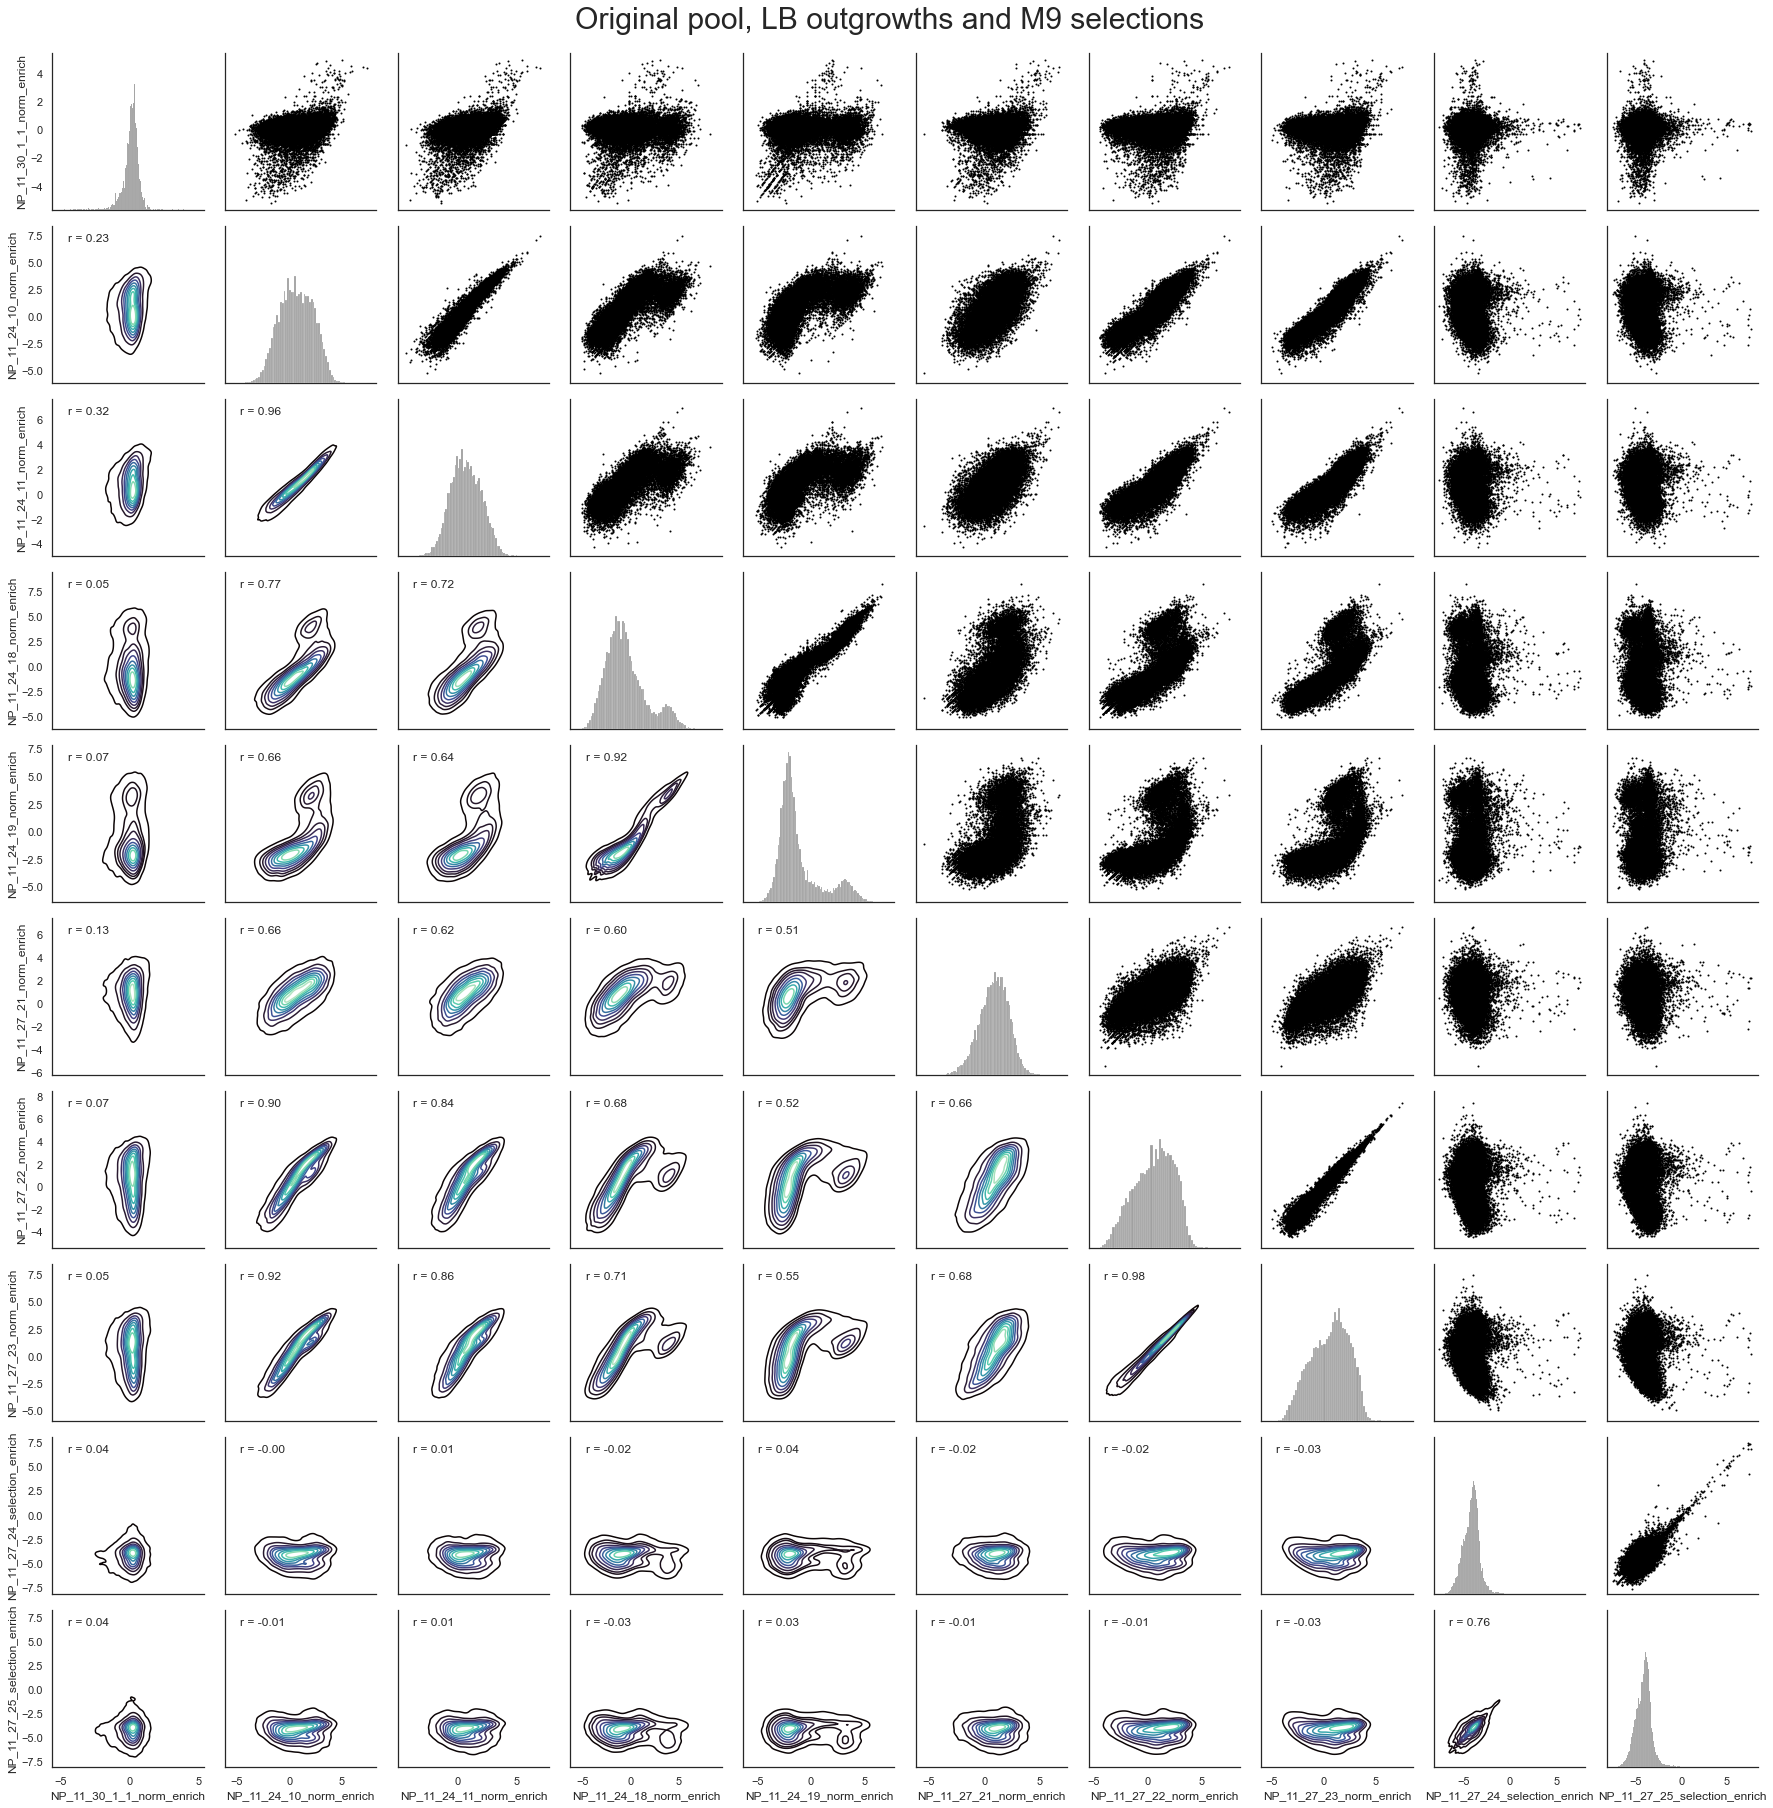

In [10]:
# Pairplot of enrichment values

dataForPairplot = [illuminaGlycerol] + outgrowths
columnsForPairplot = []
for experiment in dataForPairplot:
    columnsForPairplot.append(experiment + '_norm_enrich')
for experiment in  selections:
    columnsForPairplot.append(experiment + '_selection_enrich')
pairplotData = BCDF[columnsForPairplot].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Original pool, LB outgrowths and M9 selections", y=1.01, size = 30)

Text(0.5, 1.01, 'Original pool, LB outgrowths and M9 selections mutant averages')

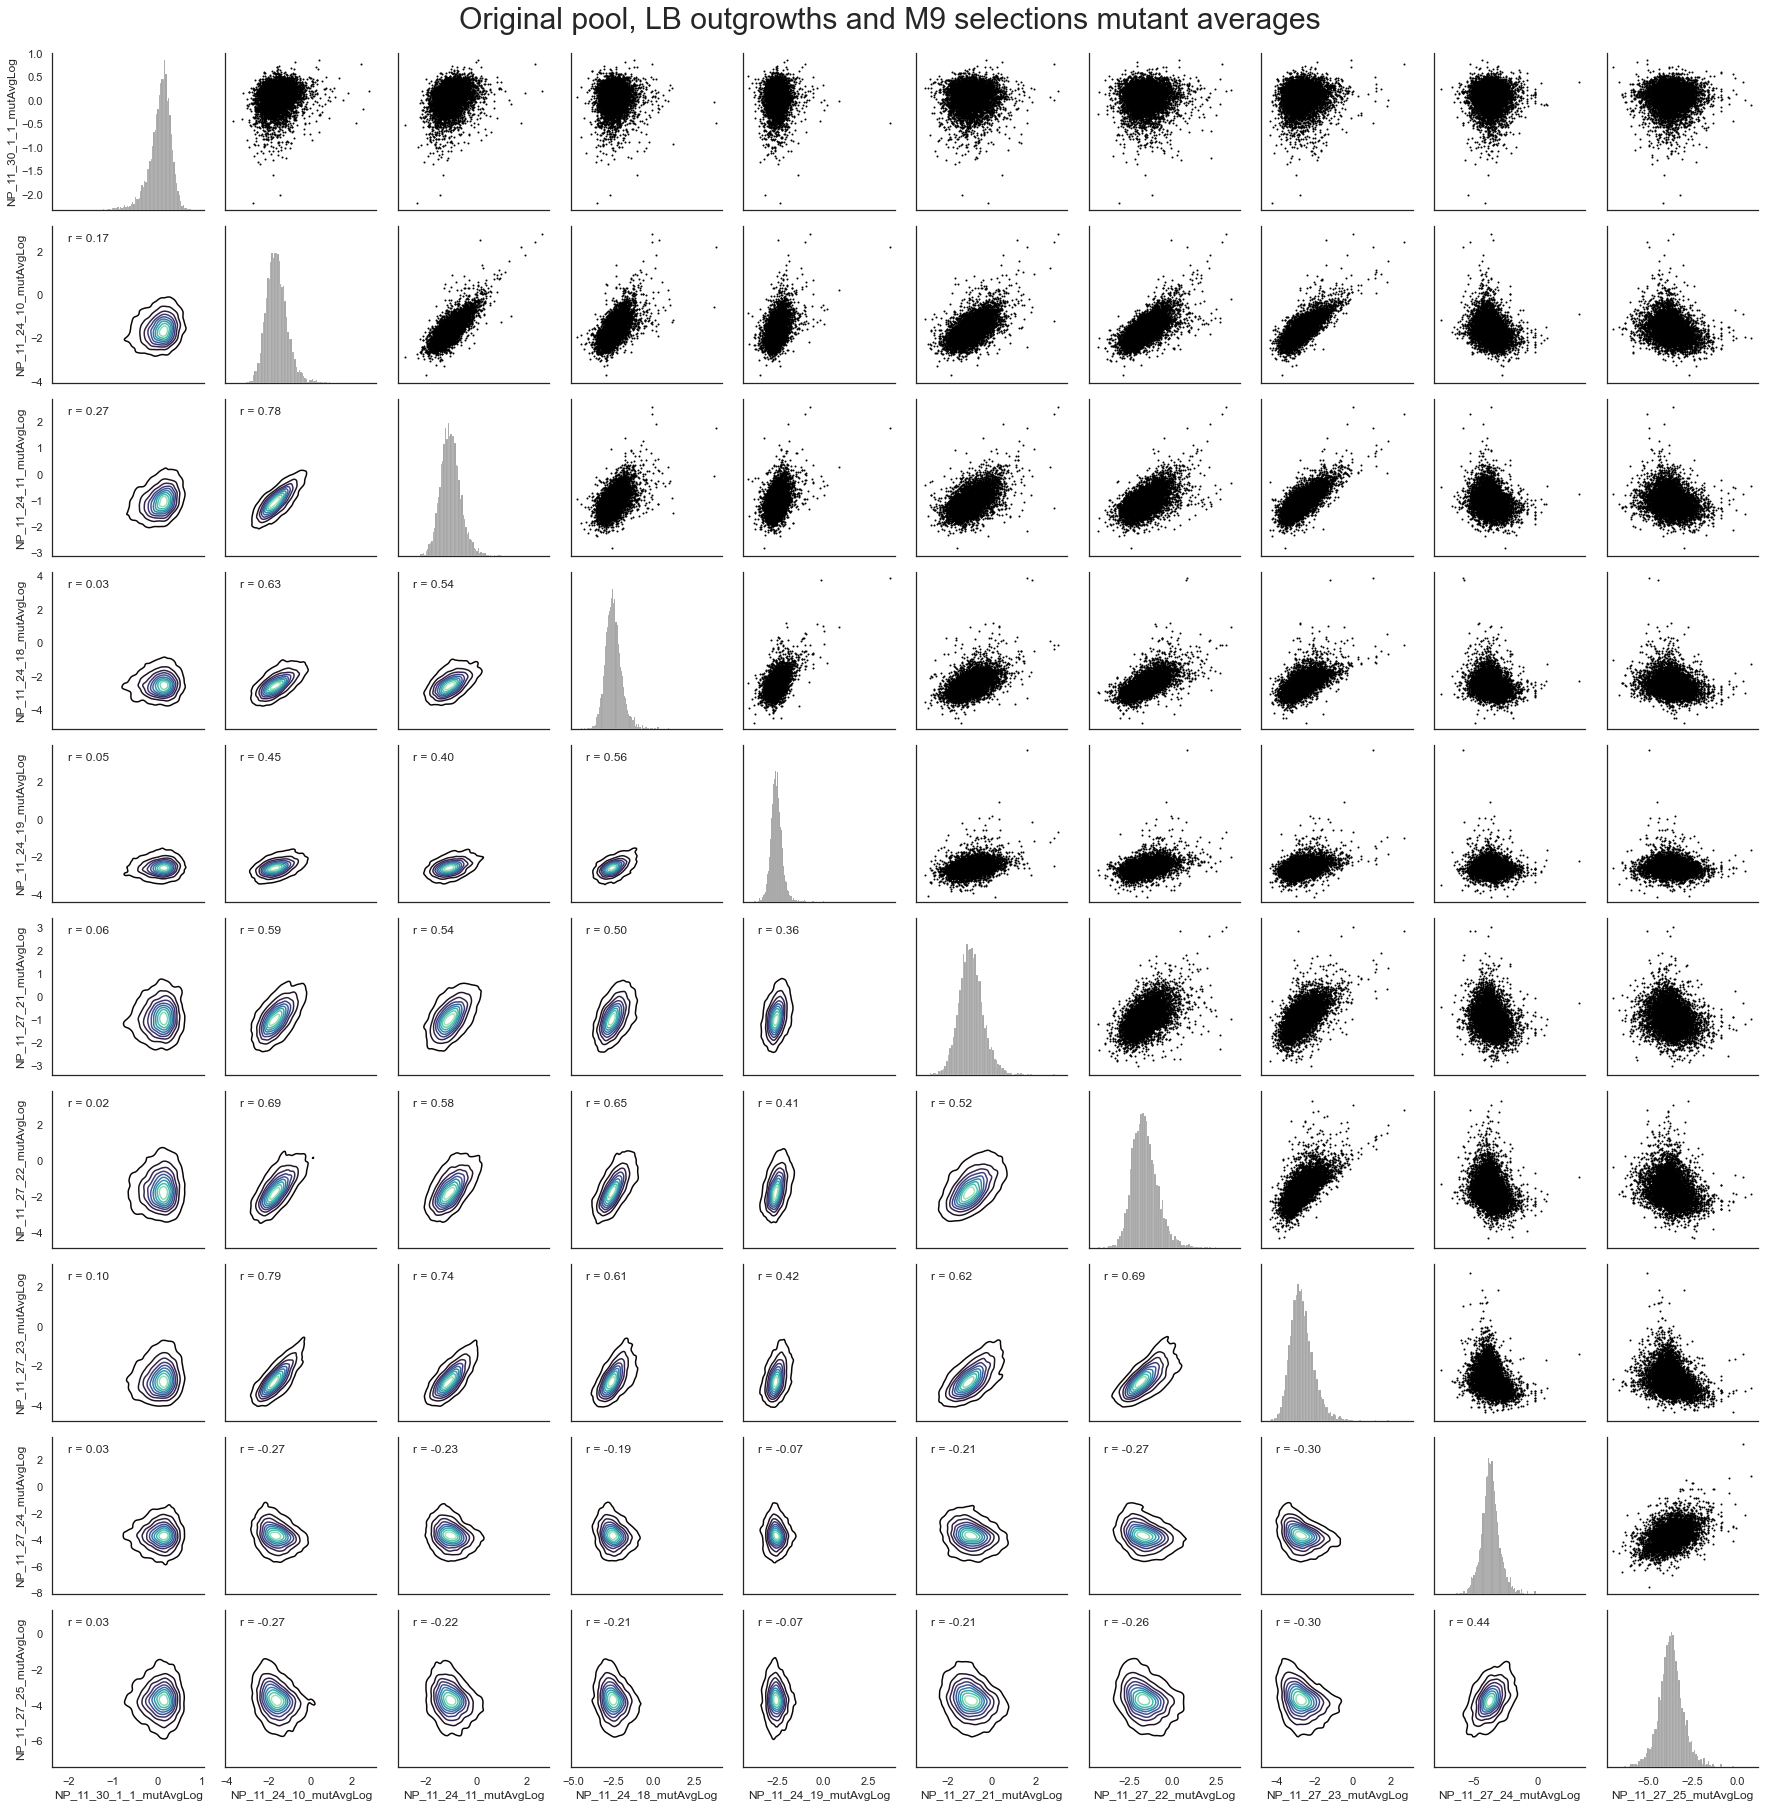

In [11]:
# Pairplots for averages across mutants

dataForPairplot = [illuminaGlycerol] + outgrowths + selections
columnsForPairplot = []
for experiment in dataForPairplot:
    columnsForPairplot.append(experiment + '_mutAvgLog')
pairplotData = mutDF[columnsForPairplot].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Original pool, LB outgrowths and M9 selections mutant averages", y=1.01, size = 30)

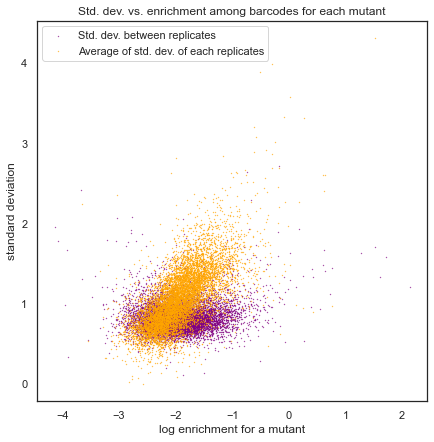

In [12]:
# Std. dev. vs. average enrichment by mutation in outgrowths
# Do both std. dev.s, among barcodes of a mutant averaged across replicates
#    And between replicates

plt.scatter(mutDF['outgrowths_mut_avg'], mutDF['outgrowths_mut_stDev'], 
            s = 0.1, color = 'purple', label = 'Std. dev. between replicates')
plt.scatter(mutDF['outgrowths_mut_avg'], mutDF['outgrowths_mut_avg_of_rep_stDevs'], 
            s = 0.1, color = 'orange', label = 'Average of std. dev. of each replicates')

plt.title('Std. dev. vs. enrichment among barcodes for each mutant')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()



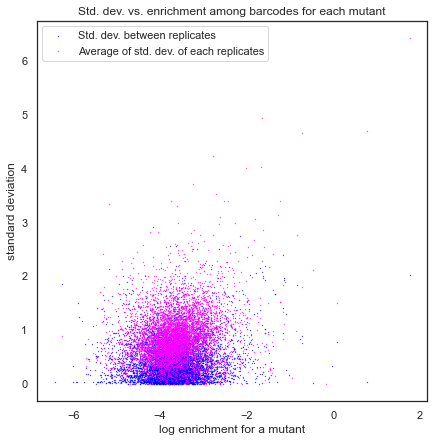

In [13]:
# Std. dev. vs. average enrichment by mutation in selections
# Do both std. dev.s, among barcodes of a mutant averaged across replicates
#    And between replicates

plt.scatter(mutDF['selections_mut_avg'], mutDF['selections_mut_stDev'], 
            s = 0.1, color = 'blue', label = 'Std. dev. between replicates')
plt.scatter(mutDF['selections_mut_avg'], mutDF['selections_mut_avg_of_rep_stDevs'], 
            s = 0.1, color = 'magenta', label = 'Average of std. dev. of each replicates')

plt.title('Std. dev. vs. enrichment among barcodes for each mutant')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()

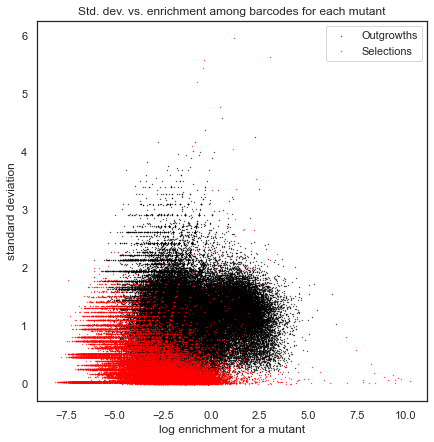

In [14]:
# Std. dev. vs. average enrichment by barcode in outgrowths and selections


plt.scatter(BCDF['outgrowths_avg'], BCDF['outgrowths_stDev'], 
            s = 0.1, color = 'black', label = 'Outgrowths')
plt.scatter(BCDF['selections_avg'], BCDF['selections_stDev'], 
            s = 0.1, color = 'red', label = 'Selections')

plt.title('Std. dev. vs. enrichment among barcodes for each mutant')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()

In [15]:
BCDF[BCDF['correctedAAmut'] == 'K191A']

,index,Barcode,correctedAAmut,NP_11_25,NP_11_30_1_1,NP_11_24_10,NP_11_24_11,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_27_24,NP_11_27_25,NP_11_30_1_1_norm_enrich,NP_11_24_10_norm_enrich,NP_11_24_11_norm_enrich,NP_11_24_18_norm_enrich,NP_11_24_19_norm_enrich,NP_11_27_21_norm_enrich,NP_11_27_22_norm_enrich,NP_11_27_23_norm_enrich,NP_11_27_24_norm_enrich,NP_11_27_25_norm_enrich,NP_11_27_24_selection_enrich,NP_11_27_25_selection_enrich,NP_11_30_1_1_mutAvgLog,NP_11_30_1_1_mutStDevLog,NP_11_24_10_mutAvgLog,NP_11_24_10_mutStDevLog,NP_11_24_11_mutAvgLog,NP_11_24_11_mutStDevLog,NP_11_24_18_mutAvgLog,NP_11_24_18_mutStDevLog,NP_11_24_19_mutAvgLog,NP_11_24_19_mutStDevLog,NP_11_27_21_mutAvgLog,NP_11_27_21_mutStDevLog,NP_11_27_22_mutAvgLog,NP_11_27_22_mutStDevLog,NP_11_27_23_mutAvgLog,NP_11_27_23_mutStDevLog,NP_11_27_24_mutAvgLog,NP_11_27_24_mutStDevLog,NP_11_27_25_mutAvgLog,NP_11_27_25_mutStDevLog,outgrowths_avg,outgrowths_stDev,selections_avg,selections_stDev
76738,186252.0,ACTACTGACTGTCGC,K191A,10.0,52.0,1.0,5.0,NaN,NaN,1.0,NaN,7.0,NaN,NaN,1.331621,-2.492350,-0.648678,NaN,NaN,-1.997006,NaN,-3.059098,NaN,NaN,NaN,NaN,0.581074,0.463372,-1.548288,2.137759,-0.225661,1.035666,-2.530346,1.340041,-2.614644,0.776549,-1.039236,1.739184,-1.806908,2.736779,-2.151521,2.426812,-4.984661,NaN,-3.670264,1.627331,-2.049283,1.029637,NaN,NaN
76739,257343.0,TTTGGGGCTTCAGCG,K191A,32.0,71.0,1.0,16.0,2.0,5.0,2.0,2.0,10.0,NaN,1.0,0.479907,-3.655501,-0.648678,-2.963710,-2.198143,-2.467010,-2.345236,-3.865573,NaN,-6.385140,NaN,-2.519567,0.581074,0.463372,-1.548288,2.137759,-0.225661,1.035666,-2.530346,1.340041,-2.614644,0.776549,-1.039236,1.739184,-1.806908,2.736779,-2.151521,2.426812,-4.984661,NaN,-3.670264,1.627331,-2.591979,1.072328,-6.385140,NaN
76740,261125.0,TCTGCTTGCTTCTCC,K191A,36.0,73.0,249.0,154.0,23.0,9.0,96.0,210.0,4195.0,34.0,42.0,0.389903,1.744169,1.497902,-0.639146,-1.728139,1.286408,2.190942,2.055707,-2.928954,-2.765254,-4.984661,-4.820961,0.581074,0.463372,-1.548288,2.137759,-0.225661,1.035666,-2.530346,1.340041,-2.614644,0.776549,-1.039236,1.739184,-1.806908,2.736779,-2.151521,2.426812,-4.984661,NaN,-3.670264,1.627331,0.915406,1.499780,-2.847104,0.115754
76741,262177.0,AAGCTGCGTGCGGTG,K191A,38.0,97.0,24.0,32.0,3.0,2.0,40.0,1.0,57.0,NaN,NaN,0.620088,-0.649297,-0.127381,-2.730095,-3.286284,0.356872,-3.210233,-2.296958,NaN,NaN,NaN,NaN,0.581074,0.463372,-1.548288,2.137759,-0.225661,1.035666,-2.530346,1.340041,-2.614644,0.776549,-1.039236,1.739184,-1.806908,2.736779,-2.151521,2.426812,-4.984661,NaN,-3.670264,1.627331,-1.706197,1.528731,NaN,NaN
76742,286986.0,CGGACTCGAGGGGCG,K191A,73.0,109.0,6.0,21.0,2.0,4.0,5.0,1.0,30.0,NaN,NaN,0.083851,-2.688465,-1.201468,-3.788433,-3.246010,-2.375443,-3.863106,-3.591685,NaN,NaN,NaN,NaN,0.581074,0.463372,-1.548288,2.137759,-0.225661,1.035666,-2.530346,1.340041,-2.614644,0.776549,-1.039236,1.739184,-1.806908,2.736779,-2.151521,2.426812,-4.984661,NaN,-3.670264,1.627331,-2.964944,0.956594,NaN,NaN


In [16]:
BCDF[BCDF['correctedAAmut'] == 'H44Q']

,index,Barcode,correctedAAmut,NP_11_25,NP_11_30_1_1,NP_11_24_10,NP_11_24_11,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_27_24,NP_11_27_25,NP_11_30_1_1_norm_enrich,NP_11_24_10_norm_enrich,NP_11_24_11_norm_enrich,NP_11_24_18_norm_enrich,NP_11_24_19_norm_enrich,NP_11_27_21_norm_enrich,NP_11_27_22_norm_enrich,NP_11_27_23_norm_enrich,NP_11_27_24_norm_enrich,NP_11_27_25_norm_enrich,NP_11_27_24_selection_enrich,NP_11_27_25_selection_enrich,NP_11_30_1_1_mutAvgLog,NP_11_30_1_1_mutStDevLog,NP_11_24_10_mutAvgLog,NP_11_24_10_mutStDevLog,NP_11_24_11_mutAvgLog,NP_11_24_11_mutStDevLog,NP_11_24_18_mutAvgLog,NP_11_24_18_mutStDevLog,NP_11_24_19_mutAvgLog,NP_11_24_19_mutStDevLog,NP_11_27_21_mutAvgLog,NP_11_27_21_mutStDevLog,NP_11_27_22_mutAvgLog,NP_11_27_22_mutStDevLog,NP_11_27_23_mutAvgLog,NP_11_27_23_mutStDevLog,NP_11_27_24_mutAvgLog,NP_11_27_24_mutStDevLog,NP_11_27_25_mutAvgLog,NP_11_27_25_mutStDevLog,outgrowths_avg,outgrowths_stDev,selections_avg,selections_stDev
70340,178356.0,TACTGACTGAACTGA,H44Q,8.0,22.0,4.0,11.0,3.0,4.0,8.0,2.0,27.0,NaN,1.0,0.694564,-0.882912,0.362923,-1.171950,-1.034992,0.305579,-0.958941,-1.486027,NaN,-4.998846,NaN,-3.512818,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-0.695189,0.729627,-4.998846,NaN
70341,183672.0,TTAACATGTGGTTTC,H44Q,9.0,15.0,2.0,4.0,NaN,1.0,NaN,NaN,7.0,NaN,NaN,0.193788,-1.693842,-0.766461,NaN,-2.539069,NaN,NaN,-2.953737,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-1.988277,0.968678,NaN,NaN
70342,198739.0,TTAAGCCTGTATGTA,H44Q,13.0,26.0,3.0,4.0,1.0,NaN,2.0,NaN,7.0,NaN,NaN,0.376110,-1.656102,-1.134186,-2.756071,NaN,-1.566223,NaN,-3.321462,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-2.086809,0.913275,NaN,NaN
70343,202132.0,ATTTAAAAAGATACT,H44Q,14.0,18.0,NaN,4.0,NaN,2.0,2.0,1.0,3.0,NaN,NaN,-0.065723,NaN,-1.208294,NaN,-2.287755,-1.640331,-2.211704,-4.242868,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-2.318190,1.162756,NaN,NaN
70344,221035.0,TGAGCGCCCACGTCA,H44Q,19.0,73.0,3.0,18.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,1.028983,-2.035591,-0.009598,NaN,NaN,NaN,NaN,-3.248966,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-1.764719,1.636583,NaN,NaN
70345,225704.0,ATGATAGCATCCAGG,H44Q,19.0,64.0,9.0,21.0,3.0,2.0,9.0,3.0,48.0,NaN,NaN,0.897407,-0.936979,0.144552,-2.036948,-2.593136,-0.441636,-1.418474,-1.775661,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-1.294040,0.949617,NaN,NaN
70346,235287.0,TCGTATCTAAGGCCA,H44Q,24.0,51.0,5.0,6.0,2.0,1.0,NaN,1.0,13.0,NaN,NaN,0.436735,-1.758381,-1.341826,-2.676028,-3.519898,NaN,-2.750701,-3.315527,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-2.560393,0.856574,NaN,NaN
70347,235791.0,TAGCAAAACCGTCGT,H44Q,24.0,64.0,2.0,18.0,NaN,2.0,3.0,2.0,13.0,NaN,NaN,0.663792,-2.674671,-0.243213,NaN,-2.826751,-1.773863,-2.057553,-3.315527,NaN,NaN,NaN,NaN,0.405298,0.353145,-1.537409,0.780755,-0.650405,0.843967,-2.411044,0.695735,-2.425724,0.647775,-0.951551,0.806098,-1.83001,0.66034,-2.831904,0.98142,-4.359028,NaN,-3.707982,0.492883,-2.148597,1.08421

In [17]:
BCDF[BCDF['correctedAAmut'] == 'D117V']

,index,Barcode,correctedAAmut,NP_11_25,NP_11_30_1_1,NP_11_24_10,NP_11_24_11,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_27_24,NP_11_27_25,NP_11_30_1_1_norm_enrich,NP_11_24_10_norm_enrich,NP_11_24_11_norm_enrich,NP_11_24_18_norm_enrich,NP_11_24_19_norm_enrich,NP_11_27_21_norm_enrich,NP_11_27_22_norm_enrich,NP_11_27_23_norm_enrich,NP_11_27_24_norm_enrich,NP_11_27_25_norm_enrich,NP_11_27_24_selection_enrich,NP_11_27_25_selection_enrich,NP_11_30_1_1_mutAvgLog,NP_11_30_1_1_mutStDevLog,NP_11_24_10_mutAvgLog,NP_11_24_10_mutStDevLog,NP_11_24_11_mutAvgLog,NP_11_24_11_mutStDevLog,NP_11_24_18_mutAvgLog,NP_11_24_18_mutStDevLog,NP_11_24_19_mutAvgLog,NP_11_24_19_mutStDevLog,NP_11_27_21_mutAvgLog,NP_11_27_21_mutStDevLog,NP_11_27_22_mutAvgLog,NP_11_27_22_mutStDevLog,NP_11_27_23_mutAvgLog,NP_11_27_23_mutStDevLog,NP_11_27_24_mutAvgLog,NP_11_27_24_mutStDevLog,NP_11_27_25_mutAvgLog,NP_11_27_25_mutStDevLog,outgrowths_avg,outgrowths_stDev,selections_avg,selections_stDev
30173,160648.0,CATACGAAAGAACGG,D117V,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.604719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,NaN,NaN,NaN,NaN
30174,166543.0,GCCCATATAAAATTT,D117V,6.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,-0.499359,NaN,NaN,NaN,-2.133604,NaN,NaN,-3.801035,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-2.967319,1.179052,NaN,NaN
30175,167842.0,AGCGGTTTTACTGCT,D117V,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-2.108797,NaN,NaN,NaN,NaN,NaN,NaN,-4.494182,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-4.494182,NaN,NaN,NaN
30176,186911.0,CGCCACGCAAGAATG,D117V,10.0,24.0,6.0,1.0,1.0,2.0,1.0,NaN,8.0,4.0,NaN,0.558432,-0.700590,-2.258116,-2.493706,-1.951282,-1.997006,NaN,-2.925566,-3.788086,NaN,-0.862520,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-2.054378,0.753678,-3.788086,NaN
30177,194501.0,TGTTGGTTGTTTTGG,D117V,12.0,51.0,1.0,7.0,2.0,3.0,NaN,NaN,9.0,NaN,NaN,1.129882,-2.674671,-0.494528,-1.982881,-1.728139,NaN,NaN,-2.990105,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-1.974065,0.971181,NaN,NaN
30178,197272.0,ACAATTTGGACTGTG,D117V,12.0,21.0,1.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,0.242579,-2.674671,NaN,NaN,NaN,-1.486181,NaN,-5.187329,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-3.116060,1.889641,NaN,NaN
30179,203481.0,TATAGATAAGTATCA,D117V,16.0,16.0,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,-0.317037,NaN,-1.629508,NaN,-2.015821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-1.822664,0.273165,NaN,NaN
30180,210298.0,TGGCCCGGTGCCGCC,D117V,16.0,45.0,5.0,8.0,NaN,1.0,3.0,NaN,18.0,NaN,2.0,0.717037,-1.352915,-0.648678,NaN,-3.114433,-1.368398,NaN,-2.584640,NaN,-4.998846,NaN,-2.414206,-0.238474,1.121542,-2.258958,0.831932,-1.61576,0.754261,-2.478145,0.346895,-2.521422,0.664826,-1.747098,0.604794,-3.01998,0.20009,-3.633227,0.778342,-2.237559,1.40244,-2.91493,0.708131,-1.813813,1.006746,-4.998846,NaN
30181,220543.0,CCGTAGAGGACGACT,D117V,19.0,27.0,2.0,7.0,2.0,4.0,2.0,N

In [18]:
BCDF[BCDF['correctedAAmut'] == 'D188E']

,index,Barcode,correctedAAmut,NP_11_25,NP_11_30_1_1,NP_11_24_10,NP_11_24_11,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_27_24,NP_11_27_25,NP_11_30_1_1_norm_enrich,NP_11_24_10_norm_enrich,NP_11_24_11_norm_enrich,NP_11_24_18_norm_enrich,NP_11_24_19_norm_enrich,NP_11_27_21_norm_enrich,NP_11_27_22_norm_enrich,NP_11_27_23_norm_enrich,NP_11_27_24_norm_enrich,NP_11_27_25_norm_enrich,NP_11_27_24_selection_enrich,NP_11_27_25_selection_enrich,NP_11_30_1_1_mutAvgLog,NP_11_30_1_1_mutStDevLog,NP_11_24_10_mutAvgLog,NP_11_24_10_mutStDevLog,NP_11_24_11_mutAvgLog,NP_11_24_11_mutStDevLog,NP_11_24_18_mutAvgLog,NP_11_24_18_mutStDevLog,NP_11_24_19_mutAvgLog,NP_11_24_19_mutStDevLog,NP_11_27_21_mutAvgLog,NP_11_27_21_mutStDevLog,NP_11_27_22_mutAvgLog,NP_11_27_22_mutStDevLog,NP_11_27_23_mutAvgLog,NP_11_27_23_mutStDevLog,NP_11_27_24_mutAvgLog,NP_11_27_24_mutStDevLog,NP_11_27_25_mutAvgLog,NP_11_27_25_mutStDevLog,outgrowths_avg,outgrowths_stDev,selections_avg,selections_stDev
65311,173923.0,GACACGGTAACTTTG,D188E,7.0,10.0,1.0,4.0,NaN,NaN,1.0,NaN,2.0,NaN,3.0,0.039638,-2.135675,-0.515147,NaN,NaN,-1.640331,NaN,-3.955186,NaN,-3.766702,NaN,0.188483,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.061585,1.432962,-3.766702,NaN
65312,176731.0,CCCTTCGGGCGTGCC,D188E,8.0,10.0,NaN,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,-0.093894,NaN,-0.936360,NaN,NaN,NaN,NaN,-3.172426,NaN,NaN,NaN,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.054393,1.581137,NaN,NaN
65313,180330.0,TGCTAATGATTTGTG,D188E,8.0,8.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,-0.317037,NaN,-0.648678,NaN,NaN,NaN,NaN,-3.683252,NaN,NaN,NaN,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.165965,2.145767,NaN,NaN
65314,193026.0,ACGATTTAACTGTTG,D188E,11.0,10.0,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,-0.412347,-1.894513,-1.660279,NaN,NaN,-1.399169,NaN,-4.407171,NaN,NaN,NaN,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.340283,1.392700,NaN,NaN
65315,194279.0,AGATGAATATGTTAA,D188E,12.0,34.0,1.0,1.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN,0.724417,-2.674671,-2.440438,NaN,NaN,-2.179328,NaN,-4.494182,NaN,NaN,NaN,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.947155,1.051009,NaN,NaN
65316,206613.0,TCCCTTACTCATTAG,D188E,15.0,27.0,21.0,18.0,4.0,4.0,13.0,2.0,52.0,2.0,NaN,0.270750,0.146708,0.226790,-1.512877,-1.663600,0.162478,-1.587550,-1.459229,-4.886698,NaN,-3.427469,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-0.812469,0.929574,-4.886698,NaN
65317,221031.0,TTAGTTAACTCGGAA,D188E,18.0,32.0,NaN,5.0,8.0,1.0,1.0,NaN,7.0,NaN,NaN,0.258327,NaN,-1.236465,-1.002051,-3.232216,-2.584793,NaN,-3.646884,NaN,NaN,NaN,NaN,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.562216,0.855481,-2.305415,2.194877,-2.340482,1.180235,NaN,NaN
65318,232000.0,CTTCTAAATTGTTGG,D188E,22.0,33.0,43.0,28.0,13.0,3.0,56.0,27.0,789.0,8.0,19.0,0.088428,0.480393,0.285631,-0.717214,-2.334275,1.239888,0.632148,0.877301,-3.883396,-3.066008,-4.760698,-3.943309,0.119604,0.331033,-1.688682,1.387276,-0.971769,0.864403,-1.65763,0.855524,-2.361409,0.521581,-1.293168,1.218806,-1.769261,1.74537,-3.065959,1.540628,-3.56221

In [19]:
# Add column for barcodes/mutation

BCsPerMut = BCDF['correctedAAmut'].value_counts().to_frame().reset_index().rename(columns = 
                                        {'index': 'correctedAAmut', 'correctedAAmut':'BCsPerMut'})
mutDF = mutDF.merge(BCsPerMut, how = 'outer', on = 'correctedAAmut')


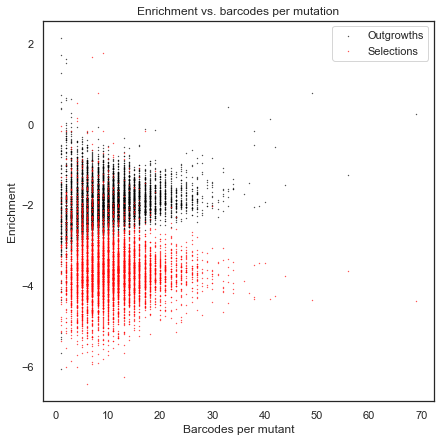

In [20]:
# Scatterplot of enrichment vs. barcodes/mutant for outgrowths and selections

plt.scatter(mutDF['BCsPerMut'], mutDF['outgrowths_mut_avg'], 
            s = 0.1, color = 'black', label = 'Outgrowths')
plt.scatter(mutDF['BCsPerMut'], mutDF['selections_mut_avg'], 
            s = 0.1, color = 'red', label = 'Selections')

plt.title('Enrichment vs. barcodes per mutation')
plt.xlabel('Barcodes per mutant')
plt.ylabel('Enrichment')
plt.legend()

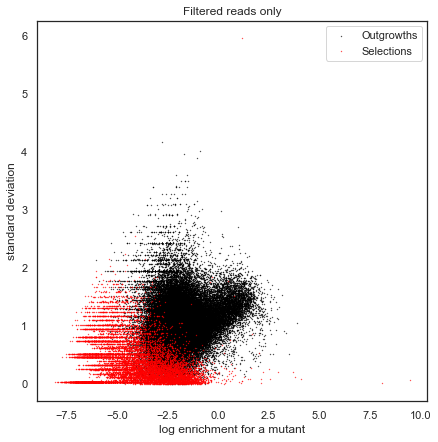

In [21]:
# Compare filtered data to indels and backbone muts

filteredLookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
bbMutLookup = 'NP_11_21_1_BB_AB_BBmuts_lookupTable.csv'
indelLookup = 'NP_11_21_1_BB_AB_indels_lookupTable.csv'

filterDF = pd.read_csv(filteredLookupTable, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'filtered', 'Barcode_sequence':'Barcode'})
bbMutDF = pd.read_csv(bbMutLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'backboneMut', 'Barcode_sequence':'Barcode'})
indelDF = pd.read_csv(indelLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'hasIndel', 'Barcode_sequence':'Barcode'})

filterDF = filterDF.merge(BCDF, how = 'left', on = 'Barcode')
bbMutDF = bbMutDF.merge(BCDF, how = 'left', on = 'Barcode')
indelDF = indelDF.merge(BCDF, how = 'left', on = 'Barcode')


plt.scatter(filterDF['outgrowths_avg'], filterDF['outgrowths_stDev'], s = 0.1, 
            color = 'black', label = 'Outgrowths')
plt.scatter(filterDF['selections_avg'], filterDF['selections_stDev'], s = 0.1, 
            color = 'red', label = 'Selections')

plt.title('Filtered reads only')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()


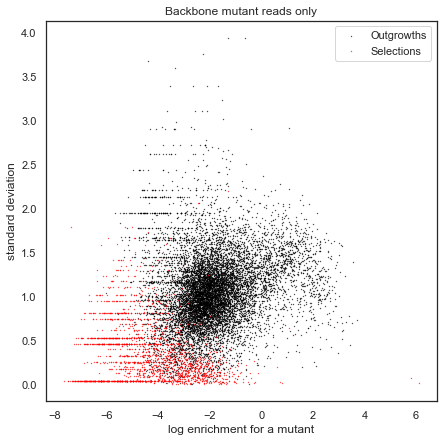

In [22]:
# Backbone mutants

plt.scatter(bbMutDF['outgrowths_avg'], bbMutDF['outgrowths_stDev'], s = 0.1, color = 'black', label = 'Outgrowths')
plt.scatter(bbMutDF['selections_avg'], bbMutDF['selections_stDev'], s = 0.1, color = 'red', label = 'Selections')

plt.title('Backbone mutant reads only')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()

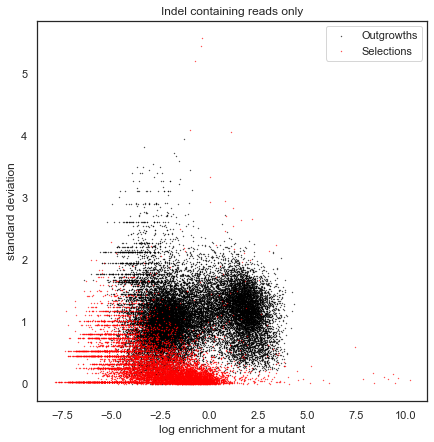

In [23]:
# Indel reads only

plt.scatter(indelDF['outgrowths_avg'], indelDF['outgrowths_stDev'], s = 0.1, color = 'black', label = 'Outgrowths')
plt.scatter(indelDF['selections_avg'], indelDF['selections_stDev'], s = 0.1, color = 'red', label = 'Selections')

plt.title('Indel containing reads only')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')
plt.legend()


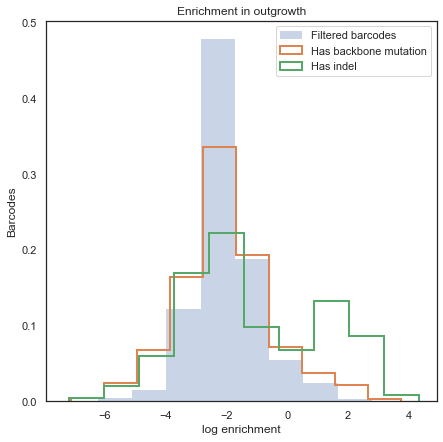

In [24]:
# Histogram of barcode enrichments

plt.hist(filterDF['outgrowths_avg'], density = True, alpha = 0.3, linewidth = 0, label = 'Filtered barcodes')
plt.hist(bbMutDF['outgrowths_avg'], density = True, histtype = 'step', linewidth = 2, label = 'Has backbone mutation')
plt.hist(indelDF['outgrowths_avg'], density = True, histtype = 'step', linewidth = 2, label = 'Has indel')
plt.title('Enrichment in outgrowth')
plt.xlabel('log enrichment')
plt.ylabel('Barcodes')
plt.legend()




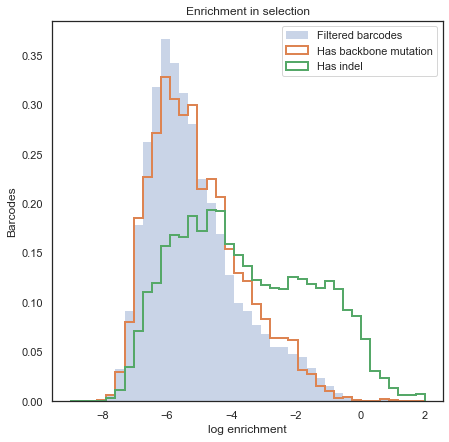

In [25]:
# Plot selection histogram

bins = np.linspace(-9, 2, 40)

plt.hist(filterDF['selections_avg'], bins = bins, density = True, alpha = 0.3, linewidth = 0, label = 'Filtered barcodes')
plt.hist(bbMutDF['selections_avg'], bins = bins, density = True, histtype = 'step', linewidth = 2, label = 'Has backbone mutation')
plt.hist(indelDF['selections_avg'], bins = bins, density = True, histtype = 'step', linewidth = 2, label = 'Has indel')
plt.title('Enrichment in selection')
plt.xlabel('log enrichment')
plt.ylabel('Barcodes')
plt.legend()



In [28]:
# Try checking if barcode GC content makes a difference

def calcGC(row):
    BC = row['Barcode']
    GC = 0
    GCcont = 0
    total = len(BC)
    for letter in BC:
        if letter == 'G' or letter == 'C':
            GC = GC + 1
    GCcont = GC/total
    return GCcont
    
    
    
BCDF['GCcontent'] = BCDF.apply(lambda row: calcGC(row), axis = 1)

BCDF

,index,Barcode,correctedAAmut,NP_11_25,NP_11_30_1_1,NP_11_24_10,NP_11_24_11,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_27_24,NP_11_27_25,NP_11_30_1_1_norm_enrich,NP_11_24_10_norm_enrich,NP_11_24_11_norm_enrich,NP_11_24_18_norm_enrich,NP_11_24_19_norm_enrich,NP_11_27_21_norm_enrich,NP_11_27_22_norm_enrich,NP_11_27_23_norm_enrich,NP_11_27_24_norm_enrich,NP_11_27_25_norm_enrich,NP_11_27_24_selection_enrich,NP_11_27_25_selection_enrich,NP_11_30_1_1_mutAvgLog,NP_11_30_1_1_mutStDevLog,NP_11_24_10_mutAvgLog,NP_11_24_10_mutStDevLog,NP_11_24_11_mutAvgLog,NP_11_24_11_mutStDevLog,NP_11_24_18_mutAvgLog,NP_11_24_18_mutStDevLog,NP_11_24_19_mutAvgLog,NP_11_24_19_mutStDevLog,NP_11_27_21_mutAvgLog,NP_11_27_21_mutStDevLog,NP_11_27_22_mutAvgLog,NP_11_27_22_mutStDevLog,NP_11_27_23_mutAvgLog,NP_11_27_23_mutStDevLog,NP_11_27_24_mutAvgLog,NP_11_27_24_mutStDevLog,NP_11_27_25_mutAvgLog,NP_11_27_25_mutStDevLog,outgrowths_avg,outgrowths_stDev,selections_avg,selections_stDev,GCcontent
0,155046.0,GAAGACGTCATCCAA,E154M,4.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-0.093894,-1.576059,-0.648678,NaN,NaN,NaN,NaN,-4.088717,NaN,NaN,NaN,NaN,0.096558,0.367908,-1.803425,0.914673,-0.947948,0.936915,-2.557267,1.134557,-2.512845,0.654025,-0.62107,1.140855,-1.620248,0.964625,-3.034407,1.498149,-2.999848,1.812409,-4.25603,0.813675,-2.104485,1.779857,NaN,NaN,0.466667
1,161231.0,AGATAATTAAGGTCT,E154M,5.0,7.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,0.019435,-1.799203,-1.564969,NaN,NaN,NaN,-1.182085,-4.311861,-4.481233,NaN,-0.169373,NaN,0.096558,0.367908,-1.803425,0.914673,-0.947948,0.936915,-2.557267,1.134557,-2.512845,0.654025,-0.62107,1.140855,-1.620248,0.964625,-3.034407,1.498149,-2.999848,1.812409,-4.25603,0.813675,-2.214529,1.421169,-4.481233,NaN,0.266667
2,164311.0,ACGCTCTCAACAAAG,E154M,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096558,0.367908,-1.803425,0.914673,-0.947948,0.936915,-2.557267,1.134557,-2.512845,0.654025,-0.62107,1.140855,-1.620248,0.964625,-3.034407,1.498149,-2.999848,1.812409,-4.25603,0.813675,NaN,NaN,NaN,NaN,0.466667
3,176429.0,TGCTCACACAAGTGA,E154M,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.781864,NaN,NaN,NaN,NaN,0.096558,0.367908,-1.803425,0.914673,-0.947948,0.936915,-2.557267,1.134557,-2.512845,0.654025,-0.62107,1.140855,-1.620248,0.964625,-3.034407,1.498149,-2.999848,1.812409,-4.25603,0.813675,-4.781864,NaN,NaN,NaN,0.466667
4,205371.0,TAAGCTAATGCGCTA,E154M,14.0,17.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,-0.122881,-2.828822,-2.594589,NaN,NaN,-1.640331,NaN,NaN,NaN,NaN,NaN,NaN,0.096558,0.367908,-1.803425,0.914673,-0.947948,0.936915,-2.557267,1.134557,-2.512845,0.654025,-0.62107,1.140855,-1.620248,0.964625,-3.034407,1.498149,-2.999848,1.812409,-4.25603,0.813675,-2.354581,0.629548,NaN,NaN,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998677,NaN,CTTTCCCACTTCAGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466667
1998678,NaN,GTCTTGCAGGATTTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000
1998679,NaN,AAGACGACTAAAAGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000
1998680,NaN,TAAGCCCACTTCATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000


(array([6.06000e+02, 0.00000e+00, 5.31100e+03, 4.00000e+00, 2.37100e+04,
        6.00000e+00, 7.13720e+04, 1.00000e+01, 1.54692e+05, 1.00000e+01,
        2.55606e+05, 1.10000e+01, 3.35803e+05, 2.00000e+01, 3.56573e+05,
        4.40000e+01, 3.14989e+05, 2.00000e+01, 2.30088e+05, 1.00000e+01,
        1.40555e+05, 6.00000e+00, 6.97020e+04, 6.00000e+00, 2.81740e+04,
        3.00000e+00, 8.89100e+03, 1.00000e+00, 2.15500e+03, 3.04000e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

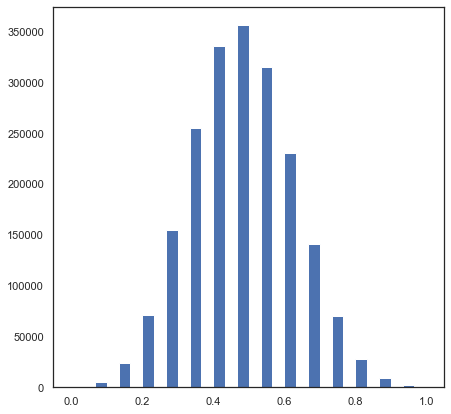

In [29]:
plt.hist(BCDF['GCcontent'], bins = 30)

Text(0.5, 1.01, 'GC content vs. outgrowths vs. selection')

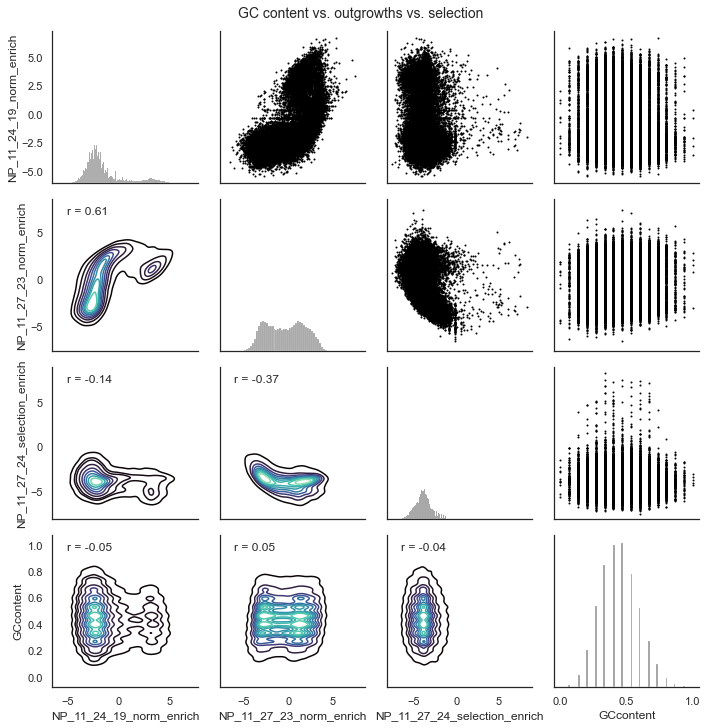

In [30]:
# Pairplot of GC vs a few datasets

# Choose relevant data
pairplotData = BCDF[['NP_11_24_19_norm_enrich', 'NP_11_27_23_norm_enrich', 'NP_11_27_24_selection_enrich', 'GCcontent']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("GC content vs. outgrowths vs. selection", y=1.01, size = 14)